In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import cvxpy as cp

np.random.seed(0)

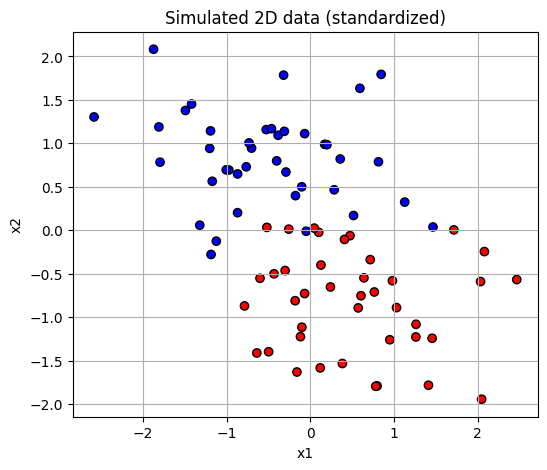

In [19]:
# Generate a simple 2D, linearly separable dataset
X, y = datasets.make_blobs(n_samples=80, centers=2, n_features=2, cluster_std=1.0)
# Make labels in {-1, +1}
y = 2*(y) - 1


# Standardize features for numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='bwr', edgecolors='k')
plt.title('Simulated 2D data (standardized)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

In [20]:
# Build Q = (y y^T) * (X X^T)
n = X_scaled.shape[0]
Y = y.reshape(-1,1)
K = X_scaled @ X_scaled.T # linear kernel matrix
Q = (Y @ Y.T) * K


# cvxpy requires a symmetric PSD matrix for quad_form; ensure symmetry
Q = 0.5*(Q + Q.T)


# Vector of ones
ones = np.ones(n)


# Regularization parameter
C = 1.0


print('Shape Q:', Q.shape)

Shape Q: (80, 80)


In [21]:
# Define variable
alpha = cp.Variable(n)

Q = cp.psd_wrap(Q)

# Objective: (1/2) alpha^T Q alpha - 1^T alpha
objective = cp.Minimize(0.5 * cp.quad_form(alpha, Q) - ones.T @ alpha)


# Constraints: 0 <= alpha <= C, y^T alpha == 0
constraints = [alpha >= 0, alpha <= C, y @ alpha == 0]


prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.OSQP, verbose=False)


print('Status:', prob.status)
print('Optimal value (dual objective):', prob.value)


alpha_opt = alpha.value
print('Some alpha values (first 10):', alpha_opt[:10])

Status: optimal
Optimal value (dual objective): -15.05072972127072
Some alpha values (first 10): [ 1.00000000e+00 -4.25977557e-20 -5.00953861e-20 -9.27348200e-20
 -3.44903240e-20 -2.43531229e-20 -3.44413143e-21 -1.93223025e-20
 -2.08385454e-20 -3.49701758e-20]


In [22]:
# Compute w = sum_i alpha_i y_i x_i
w = (alpha_opt * y) @ X_scaled


# Support vectors: those with alpha > eps (and typically < C for margin SVs)
eps = 1e-5
sv_mask = alpha_opt > eps
sv_indices = np.where(sv_mask)[0]


# Compute bias b by averaging over support vectors with 0 < alpha < C (i.e., margin SVs)
margin_sv_mask = (alpha_opt > eps) & (alpha_opt < C - 1e-8)
if margin_sv_mask.sum() > 0:
    b_vals = []
    for i in np.where(margin_sv_mask)[0]:
        b_vals.append(y[i] - X_scaled[i].dot(w))
    b = np.mean(b_vals)
else:
    # fallback: average over all support vectors
    b = np.mean([y[i] - X_scaled[i].dot(w) for i in sv_indices])


print('w:', w)
print('b:', b)
print('Number of support vectors:', sv_mask.sum())

w: [ 0.56666178 -2.36165937]
b: 0.0369651671498234
Number of support vectors: 19


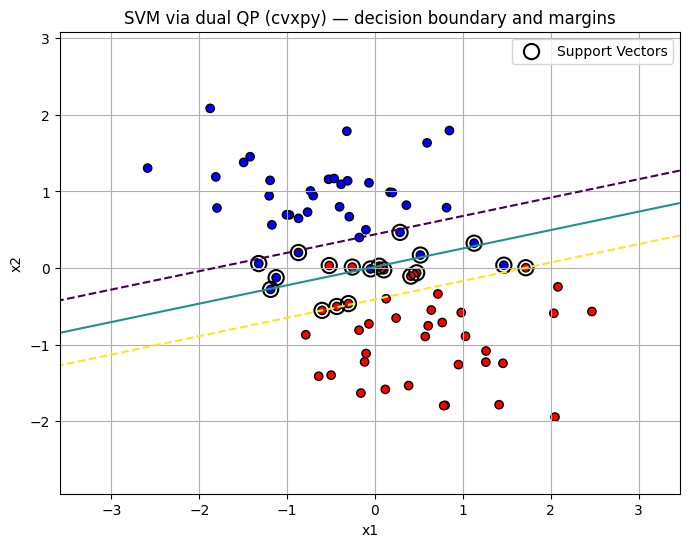

In [23]:
# helper to plot
xx = np.linspace(X_scaled[:,0].min()-1, X_scaled[:,0].max()+1, 500)
yy = np.linspace(X_scaled[:,1].min()-1, X_scaled[:,1].max()+1, 500)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
Z = grid.dot(w) + b
Z = Z.reshape(XX.shape)


plt.figure(figsize=(8,6))
# plot decision boundary and margins
plt.contour(XX, YY, Z, levels=[-1.0, 0.0, 1.0], linestyles=['--','-','--'])


# plot points
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='bwr', edgecolors='k')
# highlight support vectors
plt.scatter(X_scaled[sv_indices,0], X_scaled[sv_indices,1], s=120, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')


plt.title('SVM via dual QP (cvxpy) — decision boundary and margins')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

sklearn w: [ 0.56666184 -2.36165936]
sklearn b: 0.03696523852092982
sklearn #SV: 19


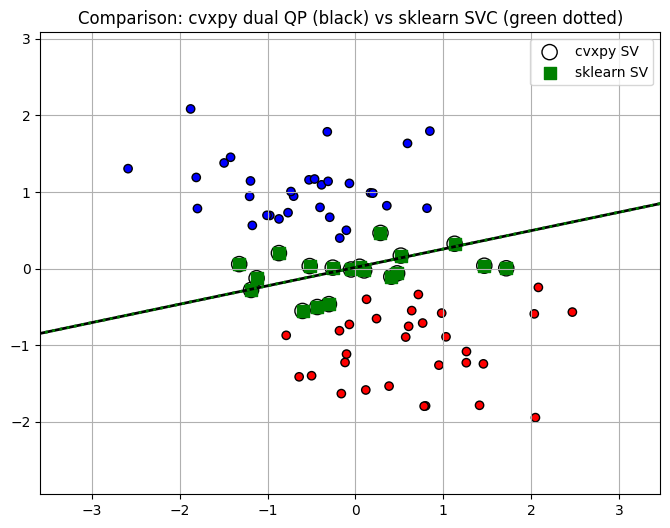

cvxpy SVM training accuracy: 0.9375
sklearn SVC training accuracy: 0.9375


In [25]:
svc = SVC(kernel='linear', C=C)
svc.fit(X_scaled, y)


# sklearn parameters
w_skl = svc.coef_.flatten()
b_skl = svc.intercept_[0]
sv_idx_skl = svc.support_


print('sklearn w:', w_skl)
print('sklearn b:', b_skl)
print('sklearn #SV:', len(sv_idx_skl))


# Plot both solutions for comparison
plt.figure(figsize=(8,6))
# cvxpy decision boundary
Z_cvx = grid.dot(w) + b
Z_cvx = Z_cvx.reshape(XX.shape)
plt.contour(XX, YY, Z_cvx, levels=[0.0], colors='k', linewidths=2, linestyles='-')
# sklearn decision boundary
Z_skl = grid.dot(w_skl) + b_skl
Z_skl = Z_skl.reshape(XX.shape)
plt.contour(XX, YY, Z_skl, levels=[0.0], colors='g', linewidths=2, linestyles=':')

plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='bwr', edgecolors='k')
plt.scatter(X_scaled[sv_indices,0], X_scaled[sv_indices,1], s=120, facecolors='none', edgecolors='k', label='cvxpy SV')
plt.scatter(X_scaled[sv_idx_skl,0], X_scaled[sv_idx_skl,1], s=80, marker='s', c='green', label='sklearn SV')
plt.title('Comparison: cvxpy dual QP (black) vs sklearn SVC (green dotted)')
plt.legend()
plt.grid(True)
plt.show()


# Quick numeric comparison
from sklearn.metrics import accuracy_score
pred_cvx = np.sign(X_scaled.dot(w) + b)
pred_skl = svc.predict(X_scaled)
print('cvxpy SVM training accuracy:', accuracy_score(y, pred_cvx))
print('sklearn SVC training accuracy:', accuracy_score(y, pred_skl))